In [1]:
from functools import reduce
from functools import partial

import matplotlib.pyplot as plt

import numpy as np

import optuna

import pandas as pd

import pickle

from PIL import Image

import plotly

import random

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import sys

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import unicodedata

from POI_engagement_classifier_utils import *

c:\Users\Lucia\.conda\envs\DeepLearningKC\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Device

In [2]:
device=(
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Mostrar información adicional del dispositivo
if device == "cuda":
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}") #Imprime nuestra GPU
    print(f"CUDA Device Count: {torch.cuda.device_count()}") #Imprime cuántas GPUs tenemos
    print(f"CUDA Device Properties: {torch.cuda.get_device_properties(0)}")

else:
    print("Using CPU")
    print(f"Number of CPU threads available: {torch.get_num_threads()}")

Using device: cuda
CUDA Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Device Count: 1
CUDA Device Properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 4060 Laptop GPU', major=8, minor=9, total_memory=8187MB, multi_processor_count=24, uuid=8e442d0f-944b-a49b-e1a7-ee0d6bb4dce0, L2_cache_size=32MB)


# Definición de semillas

In [3]:
seed = 0

set_random_seed(0)

generator = torch.Generator().manual_seed(seed)


# Importación de datos. Exploración inicial.

### Importación del CSV

In [4]:
poi_dataset = pd.read_csv("poi_dataset.csv")


### Importación de las imágenes

In [5]:
provisional_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [6]:
poi_dataset['images'] = poi_dataset['main_image_path'].apply(lambda x: load_image(x, provisional_transform))

### Exploración Inicial de los datos

##### Tipos de cada columna del dataset

In [7]:
poi_dataset.dtypes

id                   object
name                 object
shortDescription     object
categories           object
tier                  int64
locationLon         float64
locationLat         float64
tags                 object
xps                   int64
Visits                int64
Likes                 int64
Dislikes              int64
Bookmarks             int64
main_image_path      object
images               object
dtype: object

##### Comprobación de las dimensiones de las imágenes

In [8]:
first_image_shape = poi_dataset['images'].iloc[0].shape

if len(poi_dataset.loc[poi_dataset['images'].apply(lambda x: x.shape != first_image_shape)])==0:
    print(f"All images have shape {first_image_shape[0]} x {first_image_shape[1]} x {first_image_shape[2]}")
else:
    print(f"Not all images have shape {first_image_shape[0]} x {first_image_shape[1]} x {first_image_shape[2]}.")


All images have shape 3 x 128 x 128


##### Comprobación de la existencia de nulos

In [9]:
poi_dataset.isnull().sum()

id                  0
name                0
shortDescription    0
categories          0
tier                0
locationLon         0
locationLat         0
tags                0
xps                 0
Visits              0
Likes               0
Dislikes            0
Bookmarks           0
main_image_path     0
images              0
dtype: int64


# División en train, validation y test

In [10]:
train_dataset, test_dataset = train_test_split(poi_dataset, test_size=0.2, random_state=seed)


In [11]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=seed)


In [12]:
print(f"Los {len(poi_dataset)} ejemplos se han dividido en:")
print(f"{len(train_dataset)} ejemplos de train")
print(f"{len(val_dataset)} ejemplos de validación")
print(f"{len(test_dataset)} ejemplos de test")

Los 1569 ejemplos se han dividido en:
1004 ejemplos de train
251 ejemplos de validación
314 ejemplos de test


# Exploración de los datos en profundidad

### Datos estadísticos

In [13]:
train_dataset[["xps","Visits","Likes","Dislikes","Bookmarks"]].describe()

,xps,Visits,Likes,Dislikes,Bookmarks
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,746.364542,10011.775896,3510.214143,2611.469124,944.189243
std,228.478933,5.349088,4705.211411,2307.621050,1430.781870
min,0.000000,10001.000000,104.000000,52.000000,50.000000
25%,600.000000,10008.000000,445.750000,978.000000,114.750000
50%,700.000000,10011.000000,1145.500000,2734.000000,296.000000
75%,1000.000000,10015.000000,5872.750000,3405.500000,1136.500000
max,1000.000000,10038.000000,25873.000000,10999.000000,8043.000000


### Visualización de algunos ejemplos

In [14]:
train_dataset.head(5).T

,807,554,531,389,69
id,ac7176e1-3a5f-4ce0-848e-5a936953ff1b,552fd663-27aa-4b91-b95d-7e4104064dff,cc35ecae-8270-4b7c-b2b9-ba00145acdc8,e7a8427c-46e5-4610-8244-338da0e6bb00,6861fb13-c180-4d8a-a012-a1082ac240ae
name,Lugar de Encuentros I,Monumento a Alexander Pushkin,Monumento al Bombero,Palacio López-Dóriga,Xavier Fiol
shortDescription,"Descubre ""Lugar de Encuentros I"": una escultur...",¡Visita la Quinta de la Fuente del Berro! Un j...,"¡Visita ""Al Bombero""! Un emotivo homenaje a lo...",Descubre el Palacio López-Dóriga: elegancia ne...,"La Galería Xavier Fiol, fundada en 1989, centr..."
categories,"['Arquitectura', 'Cultura', 'Escultura']","['Historia', 'Escultura', 'Cultura']","['Escultura', 'Cultura', 'Historia']","['Patrimonio', 'Historia', 'Arquitectura']","['Pintura', 'Escultura']"
tier,2,1,2,2,1
locationLon,-3.681167,-3.660858,-3.764996,-3.69281,2.648026
locationLat,40.431303,40.424763,40.388012,40.421594,39.573762
tags,"['Salamanca', 'Arte', 'Fundación juan march', ...","['Madrid', 'Arte', 'Jardín artístico', 'Estatu...","['Gratitud', 'Homenaje', 'Grupo escultórico', ...","['Evolución', 'Rejería', 'Decoración', 'Uso or...",[]
xps,700,800,600,600,500
Visits,10024,10015,10014,10010,10012


### Exploración de tipos

In [15]:
train_dataset["categories"].iloc[0]

"['Arquitectura', 'Cultura', 'Escultura']"

In [16]:
train_dataset["tags"].iloc[0]

"['Salamanca', 'Arte', 'Fundación juan march', 'Cultura', 'Escultura conceptual o abstracta', 'Arquitectura', 'Escultura', 'Naturaleza', 'Espacio público', 'Vanguardia', 'Eduardo chillida', 'La castellana', 'Reflexión']"

Vemos que categories y tags son strigns, no listas. Esto quiere decir que aunque antes no hayamos detectado nulos puede que sí contengamos listas vacías convertidas a string, es decir "[]". Lo comprobamos:

### Datos sin contenido

In [17]:
print("Porcentaje de ejemplos sin categorías:")
print(f"{float(poi_dataset.loc[poi_dataset["categories"]=='[]','categories'].count())*100/len(poi_dataset):.2f}%")
print("Porcentaje de ejemplos sin tags:")
print(f"{float(poi_dataset.loc[poi_dataset["tags"]=='[]','tags'].count())*100/len(poi_dataset):.2f}%")

Porcentaje de ejemplos sin categorías:
0.13%
Porcentaje de ejemplos sin tags:
6.82%


### Exploración de variables de texto

In [18]:
for i in range(30):
    print(train_dataset['shortDescription'].iloc[i])

Descubre "Lugar de Encuentros I": una escultura de Chillida que invita a la reflexión y conexión en un entorno único.
¡Visita la Quinta de la Fuente del Berro! Un jardín artístico que une historia, naturaleza y la poesía de Pushkin.
¡Visita "Al Bombero"! Un emotivo homenaje a los valientes bomberos de Madrid. Celebra su heroísmo y dedicación.
Descubre el Palacio López-Dóriga: elegancia neogriega y rica historia en el corazón de Madrid. ¡Un tesoro arquitectónico restaurado!
La Galería Xavier Fiol, fundada en 1989, centra su actividad en la promoción de las nuevas tendencias del arte contemporáneo. 
Admira la escultura de Schultz Schreizer, homenaje a un pionero de la minería en España, obra maestra de Fructuoso Orduna.
¡Explora la tumba de Novosvobódnaya! Un enigmático dolmen de 5,000 años, testigo de la antigua cultura del Cáucaso.
Visita el osario de Sedlec, un asombroso arte funerario hecho de huesos humanos. ¡Un destino único cerca de Praga!
La tapa más clásica en el bar más clásico

Se podría generalizar que las descripciones son una enumeración de características específicas de los lugares (arte, historia, arquitectura, etc.), más que en la semántica compleja o relaciones contextuales profundas. Por tanto, una red neuronal no recurrente podría ser una opción viable. 

In [19]:
for i in range(30):
    print(train_dataset['name'].iloc[i])

Lugar de Encuentros I
Monumento a Alexander Pushkin
Monumento al Bombero
Palacio López-Dóriga
Xavier Fiol
Escultura de Luis Guillermo Schultz Schreizer
La tumba de Novosvobódnaya
El osario de Sedlec
La Tortilla de Patatas de El Pimpi
Monumento al General Martín Miguel de Güemes
Escultura "Encuentros"
Serra do Candán
Avistamiento en el monte Rainier
Igrexa de S. Pedro Fiz do Hospital do Incio
Baró
Busto de Joaquín Costa Martínez
El Castillo de Medvedgrad
Fernando III El Santo
Monumento a Miguel de Cervantes
Restos del Antiguo Palacio del Buen Retiro
Victoria Kent
Bosque de Hoia Baciu, el Triángulo de las Bermudas rumano.
Monumento a José María de Llanos Pastor
Hiberia
La ciudad de Cauno
Estatua de Bárbara de Braganza
Igrexa de Santa Mar A Nova de Noia
Monumento a Velázquez
Escultura "Amigos"
Palacio de los Duques de Santoña (Cámara de Comercio)


Al igual que con las descripciones, en la mayoría de los casos en los nombres no vemos una relación contextual profunda, por lo que no hay necesidad de que la red neuronal sea recurrente.

### Exploración de imágenes

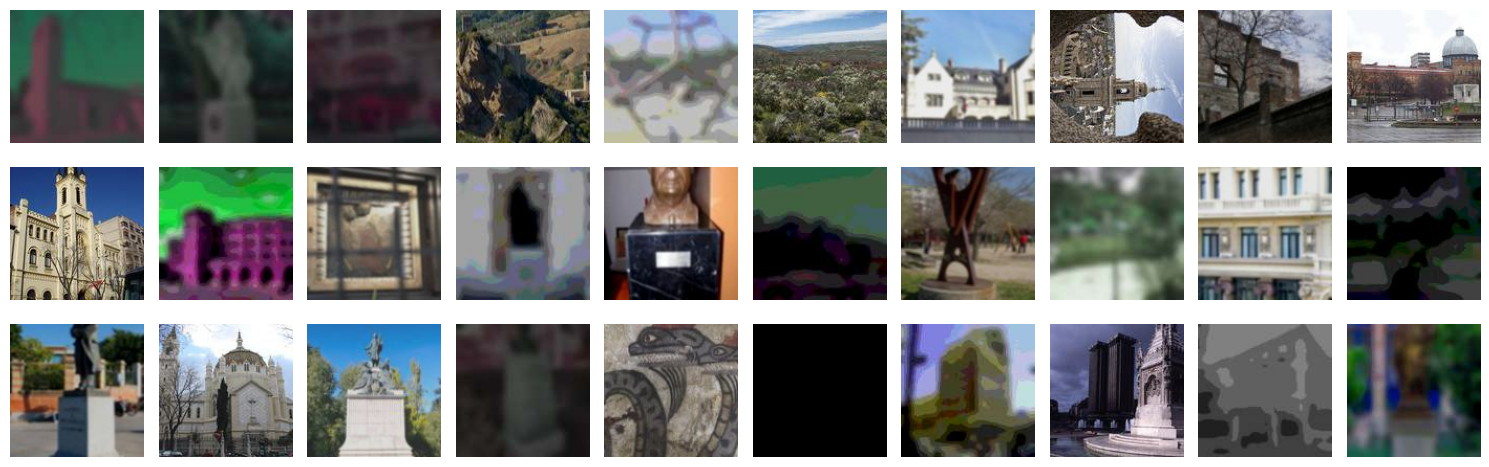

In [20]:
show_random_images(train_dataset['images'])

Vemos que algunas fotos llevan filtros de color, que hay diferencia en la calidad de las imágenes, algunas están rotadas 90º, otras están "escaladas" de forma que parece que solo se ve el centro de la imágen. Consideraremos un amplio rango de transformaciones con data augmentation para el modelo pueda aprender todas estas condiciones.

# Tratamiento de datos

### Estandarización de texto y tokenización

In [21]:
train_dataset['standarizedCategories']=train_dataset['categories'].apply(lambda x: split_text(standardize_text(x)))
val_dataset['standarizedCategories']=val_dataset['categories'].apply(lambda x: split_text(standardize_text(x)))
test_dataset['standarizedCategories']=test_dataset['categories'].apply(lambda x: split_text(standardize_text(x)))

In [22]:
print(f"Número de categorías diferentes en train: {len(column_words_counter(train_dataset["standarizedCategories"] ))}")
column_words_counter(train_dataset["standarizedCategories"])

Número de categorías diferentes en train: 12


{'arquitectura': 409,
 'cultura': 667,
 'escultura': 326,
 'historia': 833,
 'patrimonio': 380,
 'pintura': 27,
 'misterio': 235,
 'gastronomia': 10,
 'ocio': 45,
 'ciencia': 83,
 'cine': 14,
 'naturaleza': 25}

Aparentan ser categorías definidas, por lo que tiene sentido codificarlas con Multiple Hot. De esta forma, el problema de listas vacías desaparece, entendiendo que son ejemplos que no se corresponden con ninguna categoría.

In [23]:
train_dataset['standarizedTags']=train_dataset['tags'].apply(lambda x: split_text(standardize_text(x)))
val_dataset['standarizedTags']=val_dataset['tags'].apply(lambda x: split_text(standardize_text(x)))
test_dataset['standarizedTags']=test_dataset['tags'].apply(lambda x: split_text(standardize_text(x)))

In [24]:
print(f"Número de tags diferentes en train: {len(column_words_counter(train_dataset["standarizedTags"] ))}")
column_words_counter(train_dataset["standarizedTags"] )

Número de tags diferentes en train: 2100


{'salamanca': 29,
 'arte': 281,
 'fundacion': 3,
 'juan': 15,
 'march': 1,
 'cultura': 406,
 'escultura': 296,
 'conceptual': 68,
 'o': 69,
 'abstracta': 68,
 'arquitectura': 378,
 'naturaleza': 91,
 'espacio': 33,
 'publico': 42,
 'vanguardia': 2,
 'eduardo': 4,
 'chillida': 2,
 'la': 41,
 'castellana': 6,
 'reflexion': 35,
 'madrid': 466,
 'jardin': 26,
 'artistico': 6,
 'estatua': 186,
 'distrito': 29,
 'intercambio': 6,
 'cultural': 67,
 'historia': 540,
 'diplomacia': 1,
 'gratitud': 2,
 'homenaje': 51,
 'grupo': 64,
 'escultorico': 64,
 'centenario': 2,
 'seguridad': 2,
 'publica': 5,
 'valor': 1,
 'bomberos': 2,
 'aguilas': 5,
 'reconocimiento': 6,
 'monumento': 119,
 'latina': 17,
 'servicio': 3,
 'evolucion': 19,
 'rejeria': 2,
 'decoracion': 27,
 'uso': 3,
 'original': 3,
 'diseno': 26,
 'interior': 7,
 'patrimonio': 259,
 'restauracion': 78,
 'luis': 9,
 'guillermo': 1,
 'schultz': 1,
 'ingenieria': 17,
 'de': 260,
 'minas': 1,
 'rios': 4,
 'rosas': 7,
 'educacion': 62,
 'fr

No parece que los tags estén definidos, por lo que no tiene sentido codificarlo, ya que en otros ejemplos podrían ser tags totalmente diferentes.

Teniendo en cuenta que hemos descartado el tratamiento del nombre y de la descripción en su contextualización completa, podremos tokenizarlos a modo de una extensión de los tags del punto de interés.

Así, solucionamos tambien el problema de listas vacías en los tags.

Eliminaremos del conjunto extendido de tags las palabrás vacías más comunes, ya que son palabras que no aportan significado, por lo que como tags no tienen sentido.

In [25]:
stopwords = {standardize_text(word) for word in {
    # Preposiciones
    "a", "ante", "bajo", "cabe", "con", "contra", "de", "desde", "durante", "en", "entre", 
    "hacia", "hasta", "mediante", "para", "por", "según", "sin", "sobre", "tras", 

    # Determinantes
    "el", "la", "los", "las", "un", "una", "unos", "unas", "mi", "mis", "tu", "tus", "su", "sus", 
    "nuestro", "nuestra", "nuestros", "nuestras", "vuestro", "vuestra", "vuestros", "vuestras",

    # Pronombres
    "yo", "tú", "vos", "usted", "él", "ella", "nosotros", "nosotras", "vosotros", "vosotras", "ustedes", 
    "ellos", "ellas", "me", "te", "se", "nos", "os", "le", "les", "lo", "los", "la", "las", "mí", "ti", "sí",

    # Conjunciones
    "y", "e", "ni", "o", "u", "pero", "sino", "aunque", "que", "porque", "pues", "ya", "como", 
    "así", "luego", "mientras", "cuando", "si", "entonces", "tan", "tanto", "más", "menos", "incluso",

    # Adverbios comunes
    "no", "sí", "también", "tampoco", "muy", "más", "menos", "poco", "mucho", "bastante", "casi", 
    "allí", "aquí", "ahí", "allá", "ahora", "antes", "después", "luego", "mientras", "además", "aún", 
    "todavía", "siempre", "nunca", "jamás", "acaso", "quizá", "quizás",

    # Interjecciones y relleno
    "ah", "oh", "eh", "oye", "bueno", "vale", "pues", "anda", "vaya", "hombre", "claro", 
    "verdad", "entonces", "total", "seguro", "realmente", "simplemente", "evidentemente",

    # Verbos "ser", "estar", "haber" y "tener" (todas las conjugaciones)
    "ser", "soy", "eres", "es", "somos", "sois", "son", "fui", "fuiste", "fue", "fuimos", "fuisteis", "fueron",
    "era", "eras", "éramos", "erais", "eran", "seré", "serás", "será", "seremos", "seréis", "serán",
    "sería", "serías", "seríamos", "seríais", "serían", "siendo", "sido",
    "sea", "seas", "sea", "seamos", "seáis", "sean",
    "fuera", "fueras", "fuera", "fuéramos", "fuerais", "fueran",
    "fuese", "fueses", "fuese", "fuésemos", "fueseis", "fuesen",

    "estar", "estoy", "estás", "está", "estamos", "estáis", "están", "estuve", "estuviste", "estuvo",
    "estuvimos", "estuvisteis", "estuvieron", "estaba", "estabas", "estábamos", "estabais", "estaban",
    "estaré", "estarás", "estará", "estaremos", "estaréis", "estarán", "estaría", "estarías", "estaríamos",
    "estaríais", "estarían", "estando", "estado",
    "esté", "estés", "esté", "estemos", "estéis", "estén",
    "estuviera", "estuvieras", "estuviera", "estuviéramos", "estuvierais", "estuvieran",
    "estuviese", "estuvieses", "estuviese", "estuviésemos", "estuvieseis", "estuviesen",

    "haber", "he", "has", "ha", "hemos", "habéis", "han", "hube", "hubiste", "hubo", "hubimos",
    "hubisteis", "hubieron", "había", "habías", "habíamos", "habíais", "habían", "habré",
    "habrás", "habrá", "habremos", "habréis", "habrán", "habría", "habrías", "habríamos",
    "habríais", "habrían", "habiendo", "habido",
    "haya", "hayas", "haya", "hayamos", "hayáis", "hayan",
    "hubiera", "hubieras", "hubiera", "hubiéramos", "hubierais", "hubieran",
    "hubiese", "hubieses", "hubiese", "hubiésemos", "hubieseis", "hubiesen",

    "tener", "tengo", "tienes", "tiene", "tenemos", "tenéis", "tienen", "tuve", "tuviste", "tuvo",
    "tuvimos", "tuvisteis", "tuvieron", "tenía", "tenías", "teníamos", "teníais", "tenían",
    "tendré", "tendrás", "tendrá", "tendremos", "tendréis", "tendrán", "tendría", "tendrías",
    "tendríamos", "tendríais", "tendrían", "teniendo", "tenido",
    "tenga", "tengas", "tenga", "tengamos", "tengáis", "tengan",
    "tuviera", "tuvieras", "tuviera", "tuviéramos", "tuvierais", "tuvieran",
    "tuviese", "tuvieses", "tuviese", "tuviésemos", "tuvieseis", "tuviesen"
}}



In [26]:
train_dataset['extendedStandarizedTags'] = train_dataset.apply(
    lambda row: (
        list(
            (
                split_text(standardize_text(row['tags']), unique_words=True)
                | split_text(standardize_text(row['shortDescription']), unique_words=True)
                | split_text(standardize_text(row['name']), unique_words=True)
            ) - stopwords
        )
    ), axis=1
)

val_dataset['extendedStandarizedTags'] = val_dataset.apply(
    lambda row: (
        list(
            (
                split_text(standardize_text(row['tags']), unique_words=True)
                | split_text(standardize_text(row['shortDescription']), unique_words=True)
                | split_text(standardize_text(row['name']), unique_words=True)
            ) - stopwords
        )
    ), axis=1
)

test_dataset['extendedStandarizedTags'] = test_dataset.apply(
    lambda row: (
        list(
            (
                split_text(standardize_text(row['tags']), unique_words=True)
                | split_text(standardize_text(row['shortDescription']), unique_words=True)
                | split_text(standardize_text(row['name']), unique_words=True)
            ) - stopwords
        )
    ), axis=1
)

In [27]:
longest_tags_length=train_dataset['extendedStandarizedTags'].apply(len).max()

print(f'The example with more "extended tags" has {longest_tags_length} tags.')

The example with more "extended tags" has 36 tags.


In [28]:
unified_set = reduce(lambda x, y: set(x) | set(y), train_dataset['extendedStandarizedTags'])

print(f"The vocabulary size is {len(unified_set)}.")

The vocabulary size is 4265.


### Codificación de Categories

In [29]:
categories_count_dict=column_words_counter(train_dataset["standarizedCategories"])

for key in categories_count_dict.keys():
    train_dataset[key] = train_dataset["standarizedCategories"].apply(
        lambda x: 1 if key in x else 0
    )

for key in categories_count_dict.keys():
    val_dataset[key] = val_dataset["standarizedCategories"].apply(
        lambda x: 1 if key in x else 0
    )

for key in categories_count_dict.keys():
    test_dataset[key] = test_dataset["standarizedCategories"].apply(
        lambda x: 1 if key in x else 0
    )

In [30]:
train_dataset.head(1).T

,807
id,ac7176e1-3a5f-4ce0-848e-5a936953ff1b
name,Lugar de Encuentros I
shortDescription,"Descubre ""Lugar de Encuentros I"": una escultur..."
categories,"['Arquitectura', 'Cultura', 'Escultura']"
tier,2
locationLon,-3.681167
locationLat,40.431303
tags,"['Salamanca', 'Arte', 'Fundación juan march', ..."
xps,700
Visits,10024


### Definición de Engagement

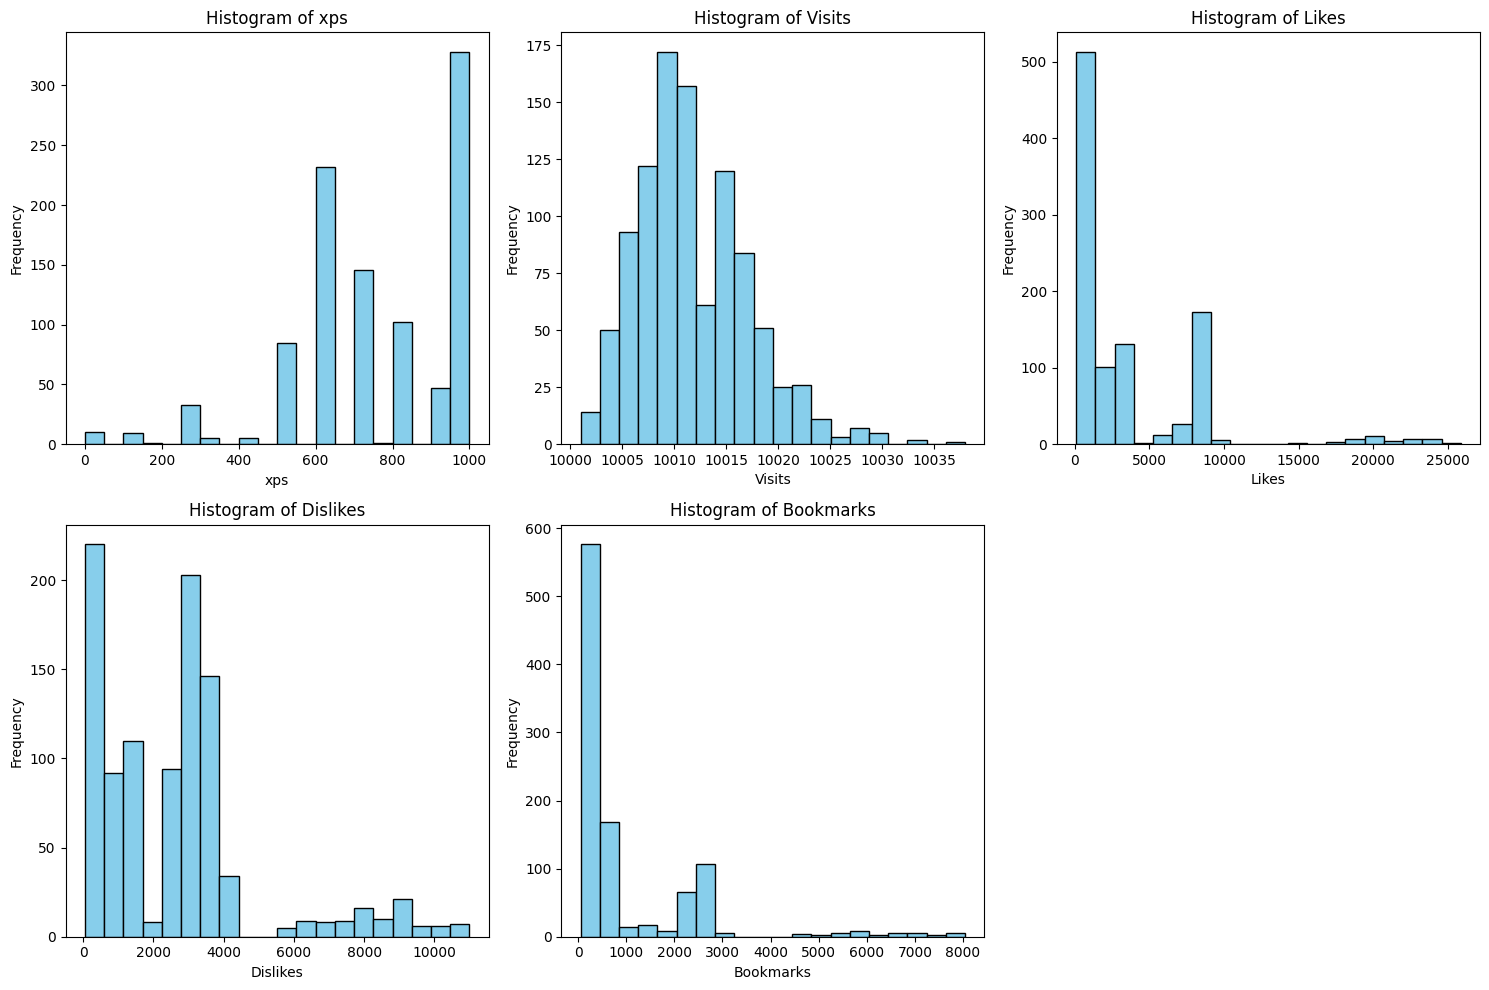

In [31]:
columns = ['xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns):
    axes[i].hist(train_dataset[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

if len(columns) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()

plt.show()


Vemos que hay una subida abrupta en la frecuencia de xps (experiencia de usuario) en su valor máximo tras una aprente tendencia de bajada en la frecuencia. Esta falta de coherencia con la tendencia general nos lleva a desestimar su uso para la obtención del engagement.

Teniendo en cuenta que el nivel de interacción del usuario es mucho mayor en el caso de los Likes, Dislikes y Bookmarks que en caso de las visitas, se propone la siguiente métrica:

$
Engagement =\frac{Likes+Bookmarks-Dislikes}{Visitas}
$

Esta métrica recoge el índice de aceptación (Likes), desafección (Dislikes) e interés (Bookmarks), normalizándolo en función de su exposición (visitas).

Esta métrica es un approach a la métrica de engagement de Redes Sociales en Marketing: (Likes + Comentarios + Compartir)/ Número de Seguidores.

La clasificación del engagengent se hará siguiendo también el approach con la clasificación de los clientes en Marketing según el NPS (Net Promoter Score). La métrica de NPS son puntuaciones enteras de 0 a 10, donde las puntuaciones de 0 a 6 son clientes detractores, de 7 u 8 son neutros, y de 9 o 10 son promotores. Análogamente, definiremos que un engagement inferior al 65% equivaldrá a uno bajo, uno mayor o igual que 65% y menor que 85% será neutro, y que uno mayor o igual que el 85% será alto.




In [32]:
train_dataset['engagement'] = (
    (
        train_dataset['Likes']
        + train_dataset['Bookmarks']
        - train_dataset['Dislikes']
    )
    / train_dataset['Visits']
)

engagement_scaler = MinMaxScaler(feature_range=(0, 100))

engagement_scaler.fit(train_dataset[['engagement']])

train_dataset[['engagement']] = engagement_scaler.transform(train_dataset[['engagement']])

In [33]:
val_dataset['engagement'] = (
    (
        val_dataset['Likes']
        + val_dataset['Bookmarks']
        - val_dataset['Dislikes']
    )
    / val_dataset['Visits']
)
val_dataset[['engagement']] = engagement_scaler.transform(val_dataset[['engagement']])


test_dataset['engagement'] = (
    (
        test_dataset['Likes']
        + test_dataset['Bookmarks']
        - test_dataset['Dislikes']
    )
    / test_dataset['Visits']
)
test_dataset[['engagement']] = engagement_scaler.transform(test_dataset[['engagement']])


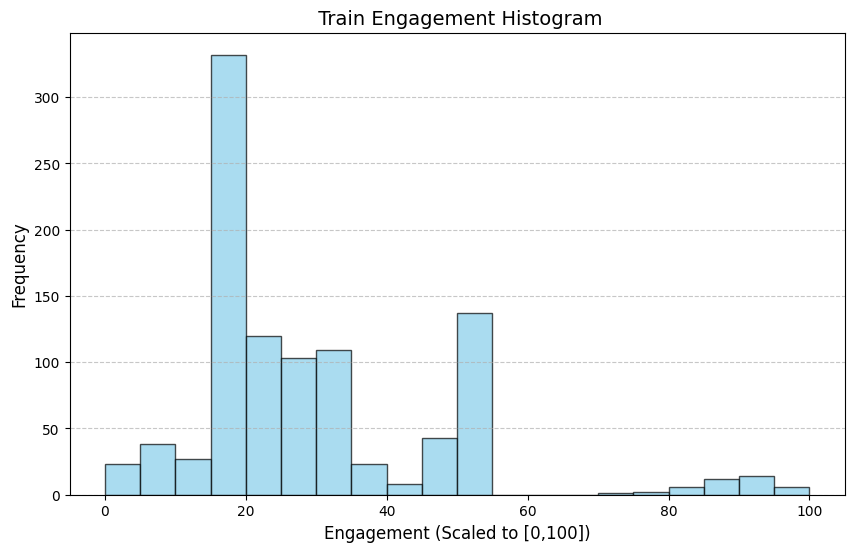

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(train_dataset['engagement'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.title(' Train Engagement Histogram', fontsize=14)
plt.xlabel('Engagement (Scaled to [0,100])', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [35]:
# 0 represents low, 1 represents neutral and 2 represents high

train_dataset['categoricalEngagement'] =\
    train_dataset['engagement'].apply(lambda x: 0 if x < 65 else (2 if x >= 85 else 1))

val_dataset['categoricalEngagement'] =\
    val_dataset['engagement'].apply(lambda x: 0 if x < 65 else (2 if x >= 85 else 1))

test_dataset['categoricalEngagement'] =\
    test_dataset['engagement'].apply(lambda x: 0 if x < 65 else (2 if x >= 85 else 1))

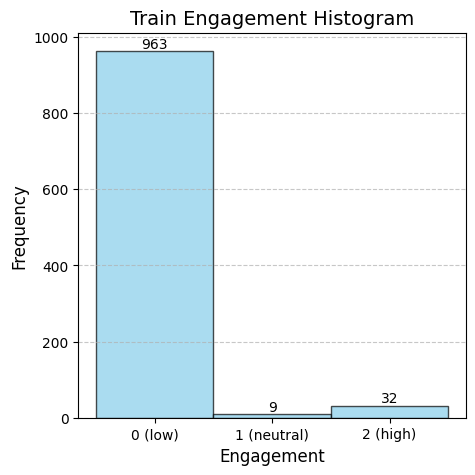

In [36]:
plt.figure(figsize=(5, 5))

bins = [0, 1, 2, 3] 

n, bins, patches = plt.hist(train_dataset['categoricalEngagement'], bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

# Labels
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, 
             n[i], 
             str(int(n[i])), 
             ha='center', 
             va='bottom', 
             fontsize=10)

plt.title('Train Engagement Histogram', fontsize=14)
plt.xlabel('Engagement', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Centering labels
bar_centers = [patch.get_x() + patch.get_width() / 2 for patch in patches]
plt.xticks(bar_centers, ['0 (low)', '1 (neutral)', '2 (high)'])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Preparación de los Datsets. Data Augmentation y Normalización.

In [37]:
train_categorical_engagement = torch.tensor(train_dataset['categoricalEngagement'].values)

val_categorical_engagement = torch.tensor(val_dataset['categoricalEngagement'].values)

test_categorical_engagement = torch.tensor(test_dataset['categoricalEngagement'].values)

In [38]:
train_tags_tokens = tokens_to_padded_indices(
    datafame_column = train_dataset['extendedStandarizedTags'],
    tokens_limit=longest_tags_length,
    padding_value=0,
    hash_limit=10000
)

val_tags_tokens = tokens_to_padded_indices(
    datafame_column = val_dataset['extendedStandarizedTags'],
    tokens_limit=longest_tags_length,
    padding_value=0,
    hash_limit=10000
)

test_tags_tokens = tokens_to_padded_indices(
    datafame_column = test_dataset['extendedStandarizedTags'],
    tokens_limit=longest_tags_length,
    padding_value=0,
    hash_limit=10000
)

In [39]:
print(list(train_dataset.columns))

['id', 'name', 'shortDescription', 'categories', 'tier', 'locationLon', 'locationLat', 'tags', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks', 'main_image_path', 'images', 'standarizedCategories', 'standarizedTags', 'extendedStandarizedTags', 'arquitectura', 'cultura', 'escultura', 'historia', 'patrimonio', 'pintura', 'misterio', 'gastronomia', 'ocio', 'ciencia', 'cine', 'naturaleza', 'engagement', 'categoricalEngagement']


In [40]:
train_multiple_hot_categories = torch.tensor(train_dataset[[
    'arquitectura', 
    'cultura', 
    'escultura', 
    'historia', 
    'patrimonio', 
    'pintura', 
    'misterio', 
    'gastronomia', 
    'ocio', 
    'ciencia', 
    'cine', 
    'naturaleza', 
    'engagement'
]].values, dtype=torch.float32)

val_multiple_hot_categories = torch.tensor(val_dataset[[
    'arquitectura', 
    'cultura', 
    'escultura', 
    'historia', 
    'patrimonio', 
    'pintura', 
    'misterio', 
    'gastronomia', 
    'ocio', 
    'ciencia', 
    'cine', 
    'naturaleza', 
    'engagement'
]].values, dtype=torch.float32)

test_multiple_hot_categories = torch.tensor(test_dataset[[
    'arquitectura', 
    'cultura', 
    'escultura', 
    'historia', 
    'patrimonio', 
    'pintura', 
    'misterio', 
    'gastronomia', 
    'ocio', 
    'ciencia', 
    'cine', 
    'naturaleza', 
    'engagement'
]].values, dtype=torch.float32)

In [41]:
train_images = torch.stack(train_dataset['images'].tolist())

val_images = torch.stack(val_dataset['images'].tolist())

test_images = torch.stack(test_dataset['images'].tolist())


In [42]:
train_images_mean = list(train_images.mean(axis=(0, 2, 3))) 
train_images_std = list(train_images.std(axis=(0, 2, 3)))

print(f"Las medias de las imágenes de train por canal son: {train_images_mean[0]:.3f}, {train_images_mean[1]:.3f}, {train_images_mean[2]:.3f}")
print(f"Las desviaciones estándar de las imágenes de train por canal son {train_images_std[0]:.3f}, {train_images_std[1]:.3f}, {train_images_std[2]:.3f}")

Las medias de las imágenes de train por canal son: 0.441, 0.438, 0.418
Las desviaciones estándar de las imágenes de train por canal son 0.267, 0.264, 0.277


Dado que tenemos muy pocos ejemplos de engagement neutro o alto, de cara a hacer data augmentation, en el caso de los engagement altos, duplicaremos los datos, manteniendo así los datos originales y haciendo las transformaciones con probabilidad de 100%. En el caso de los ejemplos con engagement bajo aplicaremos las transformaciones directamente a un porcentaje de los datos originales.

In [43]:
low_engagement_indices, neutral_engagement_indices, high_engagement_indices = [], [], []

for index, label in enumerate(train_categorical_engagement):
    if label == 0:
        low_engagement_indices.append(index)
    elif label == 1:
        neutral_engagement_indices.append(index)
    elif label == 2:
        high_engagement_indices.append(index)

Haremos las siguientes transformaciones a las imágenes:

* Volteo horizontal
* Variación de brillo y contraste
* Variación de saturación
* Rotación aleatoria
* Traslación aleatoria
* Escalado aleatorio
* Variación de tono

Para intentar aproximar el numero de muestras entre bajo, medio y alto engagement clonaremos numerosas veces las muestras de engagment medio y alto. Por facilidad el número de datasets resultante de las clonaciones será un número potencia de 2, de forma que el número final de muestras de engagent neutro y alto se aproxime lo máximo posible al número de muestras de engagement bajo. 


In [44]:
class CustomTensorDataset(Dataset):
    
    def __init__(self, x_tokens, x_multiple_hot, x_images, y_categorical, images_transform=None):
        
        if not(len(x_tokens) == len(x_multiple_hot) == len(x_images) == len(y_categorical)):
            raise ValueError("XX and y must have the same size.")
        
        self.x_tokens = x_tokens
        self.x_multiple_hot = x_multiple_hot
        self.x_images = x_images
        self.y_categorical = y_categorical
        self.images_transform = images_transform

    def __len__(self):
        return len(self.x_tokens)

    def __getitem__(self, idx):
        x_tokens = self.x_tokens[idx]
        x_multiple_hot = self.x_multiple_hot[idx]
        x_images = self.x_images[idx]
        y_categorical = self.y_categorical[idx]

        if self.images_transform:
            x_images = self.images_transform(x_images)

        return x_tokens, x_multiple_hot, x_images, y_categorical.clone().detach().long()

In [45]:
binary_numbers_32 = [format(i, '05b') for i in range(2**5)]
binary_numbers_128 = [format(i, '07b') for i in range(2**7)]
train_subdatasets = []

for binary in binary_numbers_32:
    transform_list_32 = []

    transform_list_32.append(transforms.RandomHorizontalFlip(p=0.5))
    
    if binary[0] == '1':
        transform_list_32.append(transforms.ColorJitter(brightness=(0.2, 1.8), contrast=(0.2, 1.8)))
    
    if binary[1] == '1':
        transform_list_32.append(transforms.ColorJitter(saturation = (0.2, 1.8)))
    
    if binary[2] == '1':
        transform_list_32.append(transforms.RandomAffine(degrees=90))
    
    if binary[3] == '1':
        transform_list_32.append(transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))
    
    if binary[4] == '1':
        transform_list_32.append(transforms.RandomAffine(degrees=0, scale=(0.5, 1.5)))
    
    transform_list_32.append(transforms.RandomApply([transforms.ColorJitter(hue=0.3)], p=0.5))
    
    transform_list_32.append(transforms.Normalize(mean=train_images_mean, std=train_images_std))
    
    
    train_subdatasets.append(CustomTensorDataset(
        x_tokens = train_tags_tokens[high_engagement_indices],
        x_multiple_hot = train_multiple_hot_categories[high_engagement_indices],
        x_images = train_images[high_engagement_indices],
        y_categorical = train_categorical_engagement[high_engagement_indices],
        images_transform=transforms.Compose(transform_list_32)
    ))


for binary in binary_numbers_128:
    transform_list_128 = []

    if binary[0] == '1':
        transform_list_128.append(transforms.RandomHorizontalFlip(p=1))
    
    if binary[1] == '1':
        transform_list_128.append(transforms.ColorJitter(brightness=(0.2, 1.8), contrast=(0.2, 1.8)))
    
    if binary[2] == '1':
        transform_list_128.append(transforms.ColorJitter(saturation = (0.2, 1.8)))
    
    if binary[3] == '1':
        transform_list_128.append(transforms.RandomAffine(degrees=90))
    
    if binary[4] == '1':
        transform_list_128.append(transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))
    
    if binary[5] == '1':
        transform_list_128.append(transforms.RandomAffine(degrees=0, scale=(0.5, 1.5)))
    
    if binary[6] == '1':
        transform_list_128.append(transforms.ColorJitter(hue=0.3))
    
    transform_list_128.append(transforms.Normalize(mean=train_images_mean, std=train_images_std))
    
    
    train_subdatasets.append(CustomTensorDataset(
        x_tokens = train_tags_tokens[neutral_engagement_indices],
        x_multiple_hot = train_multiple_hot_categories[neutral_engagement_indices],
        x_images = train_images[neutral_engagement_indices],
        y_categorical = train_categorical_engagement[neutral_engagement_indices],
        images_transform=transforms.Compose(transform_list_128)
    ))


train_subdatasets.append(CustomTensorDataset(
    x_tokens = train_tags_tokens[low_engagement_indices],
    x_multiple_hot = train_multiple_hot_categories[low_engagement_indices],
    x_images = train_images[low_engagement_indices],
    y_categorical = train_categorical_engagement[low_engagement_indices],
    images_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(
            [transforms.ColorJitter(brightness=(0.2, 1.8), contrast=(0.2, 1.8))],
            p=0.5
            ),
        transforms.RandomApply(
            [transforms.ColorJitter(saturation=(0.2, 1.8))],
            p=0.5
            ),
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=90)],
            p=0.5
        ),
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))],
            p=0.5
        ),
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=0, scale=(0.5, 1.5))],
            p=0.5
        ),
        transforms.RandomApply(
            [transforms.ColorJitter(hue=0.3)],
            p=0.5
            ),
        transforms.Normalize(mean=train_images_mean, std=train_images_std)
    ])
))

train_tensor_dataset = ConcatDataset(train_subdatasets)

val_tensor_dataset=CustomTensorDataset(
    x_tokens = val_tags_tokens,
    x_multiple_hot = val_multiple_hot_categories,
    x_images = val_images,
    y_categorical = val_categorical_engagement,
    images_transform=None
)

test_tensor_dataset=CustomTensorDataset(
    x_tokens = test_tags_tokens,
    x_multiple_hot = test_multiple_hot_categories,
    x_images = test_images,
    y_categorical = test_categorical_engagement,
    images_transform=None
)

# Definición del modelo e hiperparámetros fijos

### Hiperparámetros fijos

In [46]:
# Dataloaders:
batch_size = 64

#Training:
epochs_number = 10

# Scheduler:
gamma = 0.5
decay = 0.95
step_size = 5

# Embedding:
vocabulary_size = 10000

### Modelo

In [47]:
class CombinedNet(nn.Module):
    
    
    def __init__(self, vocabulary_size, dropout_rate):
        
        super(CombinedNet, self).__init__()
        
        # Embedding branch
        # input size (train_dataset[0][0].shape): 48
        self.embedding_layer = nn.EmbeddingBag(
            num_embeddings=vocabulary_size, 
            embedding_dim=64, 
            mode='mean', 
            padding_idx=0
        ) #output_size: 64
        
        self.tags_relu_layer1 = nn.Sequential(    
            nn.BatchNorm1d(64), # output size: 64
            nn.ReLU(), # output size: 64
            nn.Dropout(dropout_rate) # output size: 64 
        )
        
        self.tags_relu_layer2 = nn.Sequential(
            nn.Linear(64, 32), #output size: 32
            nn.BatchNorm1d(32), # output size: 32
            nn.ReLU(), # output size: 32
            nn.Dropout(dropout_rate) # output size: 32
        )
        


        # Simple Branch
        #input size (train_dataset[0][1].shape): 13
        self.categories_relu_layer1 = nn.Sequential(
            nn.Linear(13, 64), #output size: 64
            nn.BatchNorm1d(64), # output size: 64
            nn.ReLU(), # output size: 64
            nn.Dropout(dropout_rate) # output size: 64
        )

        self.categories_relu_layer2 = nn.Sequential(
            nn.Linear(64, 32), #output size: 32
            nn.BatchNorm1d(32), # output size: 32
            nn.ReLU(), # output size: 32        
            nn.Dropout(dropout_rate) # output size: 32
        )
        


        #Convolutional branch
        #input size (train_images_dataset[0][2].shape): 3 x 128 x 128

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, 
                out_channels=64, 
                kernel_size=3, 
                stride=1,           
                padding=1 
            ), # output size: 64 x 128 x 128
            nn.BatchNorm2d(64), # output size: 64 x 128 x 128
            nn.ReLU(), # output size: 64 x 128 x 128
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size: 64 x 64 x 64
            nn.Dropout(dropout_rate) # output size: 64 x 64 x 64
        )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, 
                out_channels=128, 
                kernel_size=3, 
                stride=1,           
                padding=1
            ), # output size: 128 x 64 x 64
            nn.BatchNorm2d(128), # output size: 128 x 64 x 64
            nn.ReLU(), # output size: 128 x 64 x 64
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size: 128 x 32 x 32
            nn.Dropout(dropout_rate) # output size: 128 x 32 x 32
        )
        
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, 
                out_channels=256, 
                kernel_size=3, 
                stride=1,           
                padding=1
            ), # output size: 256 x 32 x 32
            nn.BatchNorm2d(256), # output size: 256 x 32 x 32
            nn.ReLU(), # output size: 256 x 32 x 32
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size: 256 x 16 x 16
            nn.Dropout(dropout_rate) # output size: 256 x 16 x 16
        )
        
        self.global_avg_pool=nn.AdaptiveAvgPool2d(1) # output size: 256 x 1 x 1
        

        
        # Clasificación final
        self.output_fc = nn.Linear(32+32+256, 3) # output: 3 classes

    
    def forward(self, x_tokens, x_multiple_hot, x_images):

        # Tags:
        x_tokens = self.embedding_layer(x_tokens)
        x_tokens = self.tags_relu_layer1(x_tokens)
        x_tokens = self.tags_relu_layer2(x_tokens)
        
        # Categories:
        x_multiple_hot = self.categories_relu_layer1(x_multiple_hot)
        x_multiple_hot = self.categories_relu_layer2(x_multiple_hot)

        #Images:
        x_images = self.conv_layer1(x_images)
        x_images = self.conv_layer2(x_images)
        x_images = self.conv_layer3(x_images)
        x_images=self.global_avg_pool(x_images)
        x_images = x_images.view(x_images.size(0), -1)

        # Combined:
        x = torch.cat((x_tokens, x_multiple_hot, x_images), dim=1)
        x = self.output_fc(x)
        
        return x

# Optimización de hiperparámetros

### Función objetivo

In [48]:
def objective(trial, train_dataset, val_dataset, test_dataset, epochs_number, batch_size, check_test=False):

    """
    Objective function for hyperparameter optimization using Optuna.

    Args:
        trial (optuna.trial.Trial): The trial object that Optuna uses to suggest hyperparameters.
        train_dataset (Dataset): The training dataset.
        val_dataset (Dataset): The validation dataset.
        test_dataset (Dataset): The test dataset.
        epochs_number (int): The number of epochs to train the model.
        check_test (bool, optional): If True, the model will be evaluated on the test dataset. Defaults to False.

    Returns:
        float: The validation accuracy at the end of the training.
    """
    
    print("\n==================================================================================================================================")
    
    print(f"\nIniciando Trial #{trial.number:03d}")
    print("\n----------------------------------------------------------------------------------------------------------------------------------")
    
    
    # Seed

    trial_seed = random.randint(1, 200)
    
    set_random_seed(trial_seed)
    
    trial.set_user_attr("seed", trial_seed)
    
    print(f"\n🎲 Usando semilla: {trial_seed}")


    # Hyperparameters to optimize

    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.5)
    
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)
    
    l1_lambda = trial.suggest_float("l1_lambda", 1e-6, 1e-4, log=True)
    
    l2_lambda = trial.suggest_float("l2_lambda", 1e-4, 1e-2, log=True)
    
    criterion_key=trial.suggest_int("criterion", 1, 3, step=1)
    

    # Dataloaders

    train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size = batch_size, seed=trial_seed)
    
    
    # Model

    model = CombinedNet(vocabulary_size, dropout_rate).to(device)
    
    print(f"\n🚀 Modelo creado y movido a {device}")


    # Optimizer, scheduler, loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
    scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    scheduler = optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

    weight_tensor = torch.tensor([0.8, 1, 0.95], device=device)
    criterion={
				1: nn.CrossEntropyLoss(),
				2: nn.CrossEntropyLoss(weight = weight_tensor),
				3: nn.CrossEntropyLoss(label_smoothing=0.1)
    }[criterion_key]

    print("\n📊 Hiperparámetros seleccionados:")
    print(f"   - Dropout Rate: {dropout_rate:.3f}")
    print(f"   - Learning Rate: {learning_rate:.6f}")
    print(f"   - L1 lambda: {l1_lambda}")
    print(f"   - L2 lambda: {l2_lambda}")
    print(f"   - Criterion: {criterion}")

    print("\n🔄 Datos preparados")


    # Training

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    print("\n📈 Iniciando entrenamiento:")
    print("----------------------------------------------------------------------------------------------------------------------------------")

    pbar = tqdm(range(epochs_number), desc='Training')

    for epoch in pbar:
        
        train_loss, train_acc, current_lr = train_epoch(
            model = model,
            device = device,
            train_loader = train_loader, 
            criterion = criterion,
            optimizer = optimizer,
            l1_lambda = l1_lambda,
            scheduler = scheduler
        )

        val_loss, val_acc = eval_epoch(
            model = model,
            device = device,
            val_loader = val_loader, 
            criterion= criterion
        )

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"EPOCH: #{epoch+1}")
        print(f'Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}, Current LR: {current_lr:.5f}')
        print("----------------------------------------------------------------------------------------------------------------------------------")


    # Metrics file

    with open(f"metrics_{trial_seed}.pkl", "wb") as file_i:
        
        pickle.dump(
            {
                "train_losses": train_losses, 
                "train_accs": train_accs, 
                "val_losses": val_losses, 
                "val_accs": val_accs
            }, 
            file_i
        )
    
    
    print(f"\n💾 Métricas guardadas en metrics_{trial_seed}.pkl")
    

    trial.set_user_attr("metrics_path", f"metrics_{trial_seed}.pkl")
    

    # Evaluate test
    if check_test:
        accuracy = evaluate_model(
            model = model, 
            device = device, 
            test_loader = test_loader
        )
        
        print(f"\n🎯 Precisión en Test: {accuracy:.2f}%")
        
        trial.set_user_attr("test_accuracy", accuracy)

    print("\n✨ Trial completado ✨")
    
    print(f"Precisión final en validación: {val_accs[-1]:.2f}%")

    return val_accs[-1]

### Ejecución del estudio

In [49]:
usual_stdout=sys.stdout

sys.stdout = open("study_log.txt", "w")

try:
    optuna.delete_study(study_name="net_optimization", storage="sqlite:///net_optimization.sqlite3")
except:
    pass

study = optuna.create_study(
    study_name="net_optimization", 
    direction="maximize", 
    storage="sqlite:///net_optimization.sqlite3", 
    sampler=optuna.samplers.TPESampler()
)

study.optimize(
    partial(
        objective, 
        train_dataset = train_tensor_dataset, 
        val_dataset = val_tensor_dataset, 
        test_dataset = test_tensor_dataset, 
        epochs_number= epochs_number,
        batch_size = batch_size
    ), 
    n_trials=100
)

sys.stdout.close()
sys.stdout = usual_stdout

[I 2025-01-25 19:09:28,265] A new study created in RDB with name: net_optimization
Training: 100%|██████████| 10/10 [02:51<00:00, 17.10s/it]
[I 2025-01-25 19:12:19,446] Trial 0 finished with value: 99.60159362549801 and parameters: {'dropout_rate': 0.4579354670458251, 'learning_rate': 0.0010942655179959765, 'l1_lambda': 3.7670222020668232e-06, 'l2_lambda': 0.008408916937062041, 'criterion': 1}. Best is trial 0 with value: 99.60159362549801.
Training: 100%|██████████| 10/10 [02:42<00:00, 16.23s/it]
[I 2025-01-25 19:15:01,797] Trial 1 finished with value: 99.60159362549801 and parameters: {'dropout_rate': 0.37295052323539013, 'learning_rate': 0.005377145903038786, 'l1_lambda': 1.4697071432365023e-05, 'l2_lambda': 0.005069621825129755, 'criterion': 2}. Best is trial 0 with value: 99.60159362549801.
Training: 100%|██████████| 10/10 [02:42<00:00, 16.25s/it]
[I 2025-01-25 19:17:44,347] Trial 2 finished with value: 99.20318725099601 and parameters: {'dropout_rate': 0.3351716932917195, 'learni

### Resultados del estudio

In [50]:
loaded_study = optuna.load_study(
    study_name="net_optimization",
    storage="sqlite:///net_optimization.sqlite3"
)

print(f"Estudio cargado con {len(loaded_study.trials)} trials completados")

Estudio cargado con 100 trials completados


In [51]:
optuna.visualization.plot_param_importances(loaded_study)

In [52]:
optuna.visualization.plot_optimization_history(loaded_study)

In [53]:
optuna.visualization.plot_parallel_coordinate(loaded_study)

### Elección del trial preferido

In [59]:

completed_trials = [trial for trial in loaded_study.trials if trial.value is not None]
best_trials = sorted(completed_trials, key=lambda t: t.value, reverse=True)

print("Número de trial\t\tTrain loss\t\tVal loss\t\tTrain acc\t\tTrain acc")

for trial in best_trials:

    metrics_path = trial.user_attrs.get("metrics_path")

    with open(metrics_path, "rb") as f:
        metrics = pickle.load(f)
    
    # Filter not overfitted good metrics
    if metrics['train_losses'][-1]<1 and metrics['val_losses'][-1]<1 and metrics['train_accs'][-1]>90 and trial.value>90:
        print(f"{"#"+str(trial.number):>8}\t\t{metrics['train_losses'][-1]:>8.4f}\t\t{metrics['val_losses'][-1]:>8.4f}\t\t{metrics['train_accs'][-1]:>8.4f}\t\t{trial.value:>8.4f}")


Número de trial		Train loss		Val loss		Train acc		Train acc
     #85		  0.6513		  0.3122		 99.8407		100.0000
     #16		  0.7910		  0.3106		 99.1399		 99.6016
     #18		  0.4525		  0.3071		 99.8726		 99.6016
     #30		  0.7910		  0.3106		 99.1399		 99.6016
     #32		  0.4525		  0.3071		 99.8726		 99.6016
     #44		  0.7910		  0.3106		 99.1399		 99.6016
     #46		  0.4525		  0.3071		 99.8726		 99.6016
     #57		  0.6513		  0.3122		 99.8407		 99.6016
     #58		  0.7910		  0.3106		 99.1399		 99.6016
     #60		  0.4525		  0.3071		 99.8726		 99.6016
     #71		  0.6513		  0.3122		 99.8407		 99.6016
     #72		  0.7910		  0.3106		 99.1399		 99.6016
     #74		  0.4525		  0.3071		 99.8726		 99.6016
     #86		  0.7910		  0.3106		 99.1399		 99.6016
     #99		  0.6513		  0.3122		 99.8407		 99.6016
      #2		  0.0968		  0.0412		 99.2036		 99.2032
      #3		  0.6208		  0.3073		 99.7770		 99.2032
     #15		  0.6513		  0.3122		 99.8407		 99.2032
     #29		  0.6513		  0.3122		 99.8407		 99.2032
     #43	

In [60]:
print("Chosen trial:")
trial = loaded_study.trials[85]

print("    - Validation accuracy: ", trial.value)
print("    - Parámetros: ")
for key, value in trial.params.items():
    print(f"        - {key}: {value}")
print(f"    - Seed: {trial.user_attrs['seed']}")

Chosen trial:
    - Validation accuracy:  99.99999999999999
    - Parámetros: 
        - dropout_rate: 0.4417003083584299
        - learning_rate: 0.0018619371013620589
        - l1_lambda: 6.197785458609027e-06
        - l2_lambda: 0.00094157395640723
        - criterion: 3
    - Seed: 176


# Reproducción del modelo elegido

### Definición de hiperparámetros elegidos:

In [61]:
dropout_rate = trial.params['dropout_rate']
learning_rate = trial.params['learning_rate']
l1_lambda = trial.params['l1_lambda']
l2_lambda = trial.params['l2_lambda']
criterion_key = trial.params['criterion']
random_seed = trial.user_attrs['seed']

### Definción de la semilla

In [62]:
random_seed = trial.user_attrs['seed']

set_random_seed(random_seed)

### Creación de Dataloaders

In [63]:
train_loader, val_loader, test_loader = create_dataloaders(train_tensor_dataset, val_tensor_dataset, test_tensor_dataset, batch_size = batch_size, seed=random_seed)

### Definición del modelo

In [64]:
model = CombinedNet(vocabulary_size, dropout_rate).to(device)

### Definición de optimizador, scheduler y pérdida

In [65]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

weight_tensor = torch.tensor([0.4, 1, 0.9], device=device)
criterion={
            1: nn.CrossEntropyLoss(),
            2: nn.CrossEntropyLoss(weight = weight_tensor),
            3: nn.CrossEntropyLoss(label_smoothing=0.1)
}[criterion_key]

### Entrenamiento

In [66]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

pbar = tqdm(range(epochs_number), desc='Training')

for epoch in pbar:
    
    train_loss, train_acc, current_lr = train_epoch(
        model = model,
        device = device,
        train_loader = train_loader, 
        criterion = criterion,
        optimizer = optimizer,
        l1_lambda = l1_lambda,
        scheduler = scheduler
    )

    val_loss, val_acc = eval_epoch(
        model = model,
        device = device,
        val_loader = val_loader, 
        criterion= criterion,
        confusion_matrix=True
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
   
    pbar.set_postfix({
        'EPOCH': f'{epoch+1}'
    })
    
    print(f'Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}, Current LR: {current_lr:.5f}')

    print("----------------------------------------------------------------------------------------------------------------------------------")

Training:  10%|█         | 1/10 [00:16<02:25, 16.21s/it, EPOCH=1]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  0  2
2    0  0  4
Train loss: 3.7628674013442236, Train acc: 78.97419560369543, Val loss: 0.32614842757760765, Val acc: 99.20318725099601, Current LR: 0.00177
----------------------------------------------------------------------------------------------------------------------------------


Training:  20%|██        | 2/10 [00:31<02:05, 15.74s/it, EPOCH=2]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  0  2
2    0  0  4
Train loss: 3.156140933412015, Train acc: 94.83912073908887, Val loss: 0.31346098253451493, Val acc: 99.20318725099601, Current LR: 0.00168
----------------------------------------------------------------------------------------------------------------------------------


Training:  30%|███       | 3/10 [00:47<01:51, 15.89s/it, EPOCH=3]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.835717246045577, Train acc: 97.61070404587447, Val loss: 0.3112477271917807, Val acc: 99.99999999999999, Current LR: 0.00160
----------------------------------------------------------------------------------------------------------------------------------


Training:  40%|████      | 4/10 [01:04<01:37, 16.18s/it, EPOCH=4]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    1  1  0
2    0  0  4
Train loss: 2.605704897108561, Train acc: 97.48327492832112, Val loss: 0.3083785914804831, Val acc: 99.60159362549801, Current LR: 0.00152
----------------------------------------------------------------------------------------------------------------------------------


Training:  50%|█████     | 5/10 [01:21<01:22, 16.42s/it, EPOCH=5]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  1  1
2    0  0  4
Train loss: 2.3961583775826876, Train acc: 98.7894233832431, Val loss: 0.31055126235304603, Val acc: 99.60159362549801, Current LR: 0.00072
----------------------------------------------------------------------------------------------------------------------------------


Training:  60%|██████    | 6/10 [01:37<01:06, 16.50s/it, EPOCH=6]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    1  1  0
2    0  0  4
Train loss: 2.2590958037624014, Train acc: 98.85313794201979, Val loss: 0.30952449588186715, Val acc: 99.60159362549801, Current LR: 0.00068
----------------------------------------------------------------------------------------------------------------------------------


Training:  70%|███████   | 7/10 [01:54<00:49, 16.62s/it, EPOCH=7]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.1788653531398077, Train acc: 99.01242433896148, Val loss: 0.30754412692856503, Val acc: 99.99999999999999, Current LR: 0.00065
----------------------------------------------------------------------------------------------------------------------------------


Training:  80%|████████  | 8/10 [02:11<00:33, 16.60s/it, EPOCH=8]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.106380003658439, Train acc: 99.23542529467984, Val loss: 0.3067213835944217, Val acc: 99.99999999999999, Current LR: 0.00062
----------------------------------------------------------------------------------------------------------------------------------


Training:  90%|█████████ | 9/10 [02:27<00:16, 16.49s/it, EPOCH=9]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.0443705101991463, Train acc: 99.20356801529154, Val loss: 0.3086487571319261, Val acc: 99.99999999999999, Current LR: 0.00059
----------------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 10/10 [02:43<00:00, 16.38s/it, EPOCH=10]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.9799209633766748, Train acc: 99.29913985345657, Val loss: 0.3081987398079192, Val acc: 99.99999999999999, Current LR: 0.00028
----------------------------------------------------------------------------------------------------------------------------------


### Resultados del entrenamiento

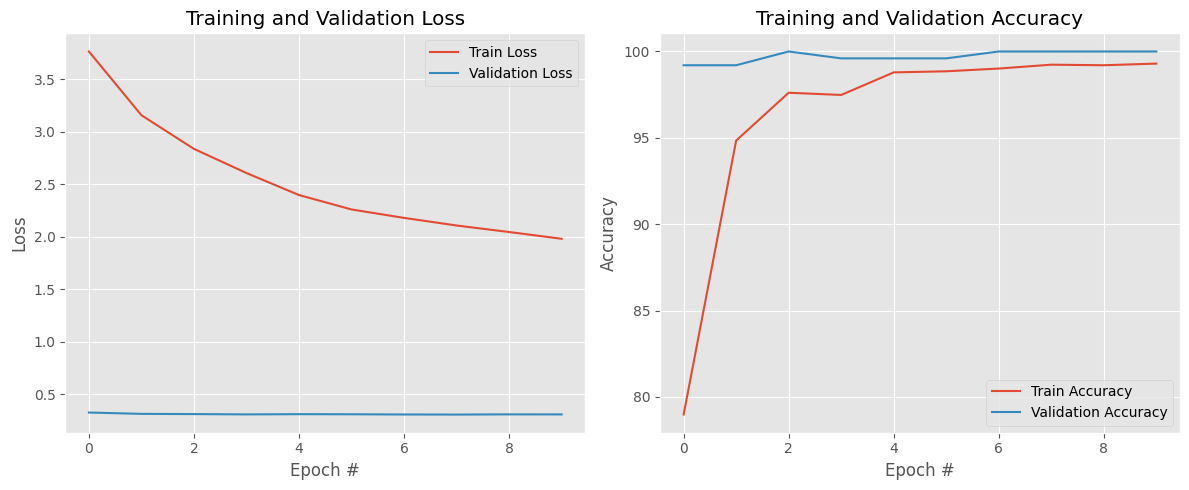

In [67]:
plot_training_curves(
    train_losses = train_losses,
    num_epochs = epochs_number,
    train_accs = train_accs, 
    val_losses = val_losses,
    val_accs = val_accs,
    test_acc=None
)


Vemos que la pérdida del modelo es baja mientras que el accuracy es muy alto. Dado que parece que el modelo aún tiene alguna muestra que aprender en train, probamos a aumentar el número de epochs.

# Definición y entrenamiento del modelo ajustado

##### Modificación de Hiperparámetros

In [68]:
epochs_number = 20

##### Reestablecimiento del modelo

In [69]:
model = CombinedNet(vocabulary_size, dropout_rate).to(device)

##### Reestablecimiento de optimizador, scheduler y pérdida

In [70]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

weight_tensor = torch.tensor([0.8, 1, 0.95], device=device)
criterion={
            1: nn.CrossEntropyLoss(),
            2: nn.CrossEntropyLoss(weight = weight_tensor),
            3: nn.CrossEntropyLoss(label_smoothing=0.1)
}[criterion_key]

##### Entrenamiento

In [71]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

pbar = tqdm(range(epochs_number), desc='Training')

for epoch in pbar:
    
    train_loss, train_acc, current_lr = train_epoch(
        model = model,
        device = device,
        train_loader = train_loader, 
        criterion = criterion,
        optimizer = optimizer,
        l1_lambda = l1_lambda,
        scheduler = scheduler
    )

    val_loss, val_acc = eval_epoch(
        model = model,
        device = device,
        val_loader = val_loader, 
        criterion= criterion,
        confusion_matrix=True
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    pbar.set_postfix({
        'EPOCH': f'{epoch+1}'
    })
    
    print(f'Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}, Current LR: {current_lr:.5f}')

    print("----------------------------------------------------------------------------------------------------------------------------------")

Training:   5%|▌         | 1/20 [00:15<05:03, 15.99s/it, EPOCH=1]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 3.7402383150208256, Train acc: 81.71392163109267, Val loss: 0.35296710981315826, Val acc: 99.99999999999999, Current LR: 0.00177
----------------------------------------------------------------------------------------------------------------------------------


Training:  10%|█         | 2/20 [00:31<04:39, 15.50s/it, EPOCH=2]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 3.139207474932468, Train acc: 95.85855367951577, Val loss: 0.3130051967394779, Val acc: 99.99999999999999, Current LR: 0.00168
----------------------------------------------------------------------------------------------------------------------------------


Training:  15%|█▌        | 3/20 [00:46<04:25, 15.65s/it, EPOCH=3]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    1  1  0
2    0  0  4
Train loss: 2.8318247006705843, Train acc: 97.51513220770948, Val loss: 0.3233994345266031, Val acc: 99.60159362549801, Current LR: 0.00160
----------------------------------------------------------------------------------------------------------------------------------


Training:  20%|██        | 4/20 [01:03<04:17, 16.08s/it, EPOCH=4]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  1  1
2    0  0  4
Train loss: 2.599954970287798, Train acc: 98.08856323669961, Val loss: 0.3106379628893864, Val acc: 99.60159362549801, Current LR: 0.00152
----------------------------------------------------------------------------------------------------------------------------------


Training:  25%|██▌       | 5/20 [01:20<04:04, 16.29s/it, EPOCH=5]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.3916479682193206, Train acc: 98.94870978018479, Val loss: 0.307252232534477, Val acc: 99.99999999999999, Current LR: 0.00072
----------------------------------------------------------------------------------------------------------------------------------


Training:  30%|███       | 6/20 [01:37<03:49, 16.43s/it, EPOCH=6]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.25977910632121, Train acc: 98.91685250079648, Val loss: 0.307247586578012, Val acc: 99.99999999999999, Current LR: 0.00068
----------------------------------------------------------------------------------------------------------------------------------


Training:  35%|███▌      | 7/20 [01:53<03:34, 16.48s/it, EPOCH=7]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.178804976122134, Train acc: 99.07613889773815, Val loss: 0.30580289549086676, Val acc: 99.99999999999999, Current LR: 0.00065
----------------------------------------------------------------------------------------------------------------------------------


Training:  40%|████      | 8/20 [02:10<03:17, 16.46s/it, EPOCH=8]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.1120994410039358, Train acc: 98.78942338324309, Val loss: 0.30679685482940827, Val acc: 99.99999999999999, Current LR: 0.00062
----------------------------------------------------------------------------------------------------------------------------------


Training:  45%|████▌     | 9/20 [02:26<03:00, 16.44s/it, EPOCH=9]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    1  1  0
2    0  0  4
Train loss: 2.043734422721997, Train acc: 99.20356801529155, Val loss: 0.3095296382666584, Val acc: 99.60159362549801, Current LR: 0.00059
----------------------------------------------------------------------------------------------------------------------------------


Training:  50%|█████     | 10/20 [02:43<02:45, 16.55s/it, EPOCH=10]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.9820686594321113, Train acc: 99.23542529467986, Val loss: 0.31158811233908057, Val acc: 99.99999999999999, Current LR: 0.00028
----------------------------------------------------------------------------------------------------------------------------------


Training:  55%|█████▌    | 11/20 [02:59<02:28, 16.54s/it, EPOCH=11]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.9372707483076526, Train acc: 99.29913985345654, Val loss: 0.3048589376814337, Val acc: 99.99999999999999, Current LR: 0.00026
----------------------------------------------------------------------------------------------------------------------------------


Training:  60%|██████    | 12/20 [03:16<02:12, 16.55s/it, EPOCH=12]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.90970448211106, Train acc: 99.20356801529151, Val loss: 0.3056706522565439, Val acc: 99.99999999999999, Current LR: 0.00025
----------------------------------------------------------------------------------------------------------------------------------


Training:  65%|██████▌   | 13/20 [03:33<01:56, 16.58s/it, EPOCH=13]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.8814586123754817, Train acc: 99.39471169162158, Val loss: 0.3047394327433461, Val acc: 99.99999999999999, Current LR: 0.00024
----------------------------------------------------------------------------------------------------------------------------------


Training:  70%|███████   | 14/20 [03:49<01:39, 16.62s/it, EPOCH=14]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.85589735030976, Train acc: 99.61771264733996, Val loss: 0.3067749218636775, Val acc: 99.99999999999999, Current LR: 0.00023
----------------------------------------------------------------------------------------------------------------------------------


Training:  75%|███████▌  | 15/20 [04:06<01:22, 16.59s/it, EPOCH=15]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.8367028848575766, Train acc: 99.17171073590319, Val loss: 0.3026815139914889, Val acc: 99.99999999999999, Current LR: 0.00011
----------------------------------------------------------------------------------------------------------------------------------


Training:  80%|████████  | 16/20 [04:22<01:06, 16.55s/it, EPOCH=16]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.8160203256664775, Train acc: 99.45842625039825, Val loss: 0.3058653528471867, Val acc: 99.99999999999999, Current LR: 0.00010
----------------------------------------------------------------------------------------------------------------------------------


Training:  85%|████████▌ | 17/20 [04:39<00:49, 16.53s/it, EPOCH=17]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.807467751003216, Train acc: 99.13985345651484, Val loss: 0.30431533085397516, Val acc: 99.99999999999999, Current LR: 0.00010
----------------------------------------------------------------------------------------------------------------------------------


Training:  90%|█████████ | 18/20 [04:55<00:33, 16.51s/it, EPOCH=18]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.7967403238842774, Train acc: 99.39471169162157, Val loss: 0.3085305598152586, Val acc: 99.99999999999999, Current LR: 0.00009
----------------------------------------------------------------------------------------------------------------------------------


Training:  95%|█████████▌| 19/20 [05:12<00:16, 16.54s/it, EPOCH=19]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.7858199871964962, Train acc: 99.55399808856328, Val loss: 0.3067002710830643, Val acc: 99.99999999999999, Current LR: 0.00009
----------------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 20/20 [05:28<00:00, 16.44s/it, EPOCH=20]

Matriz de Confusión:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.7791311726064278, Train acc: 99.26728257406822, Val loss: 0.30387680369069375, Val acc: 99.99999999999999, Current LR: 0.00004
----------------------------------------------------------------------------------------------------------------------------------


### Resultados del entrenamiento

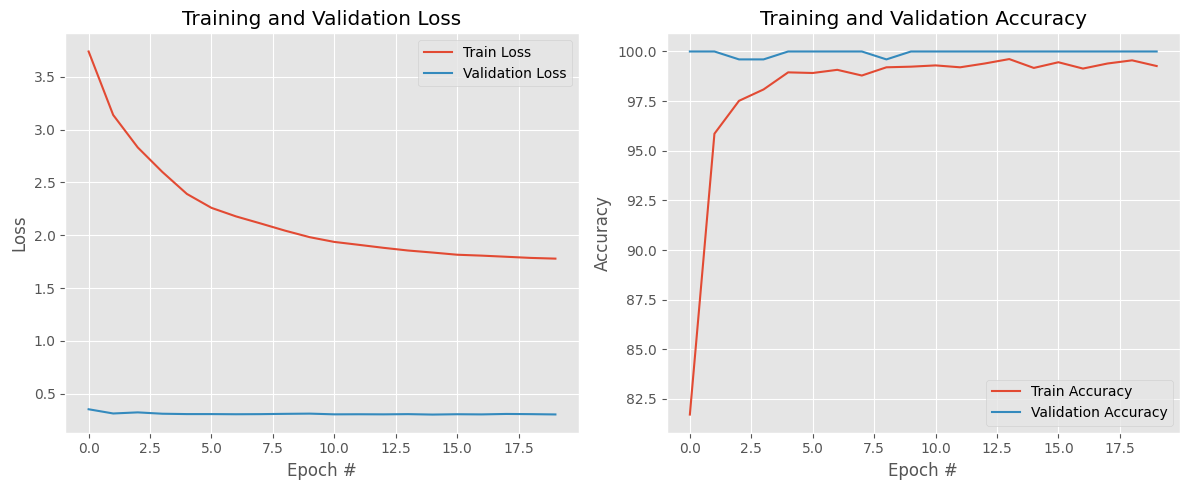

In [72]:
plot_training_curves(
    train_losses = train_losses,
    num_epochs = epochs_number,
    train_accs = train_accs, 
    val_losses = val_losses,
    val_accs = val_accs,
    test_acc=None
)

El modelo parece haberse estabilizado con un accuracy del 100% en validation y de poco más del 99% en training. Estos datos son realmente buenos. Guardamos el modelo entrenado.

In [73]:
torch.save(model.state_dict(), "trained_model.pth")

# Evaluación del modelo en test

Matriz de Confusión:
     0  1   2
0  294  0   0
1    0  0   5
2    0  0  15
La precisión del modelo en test es del 98.408%


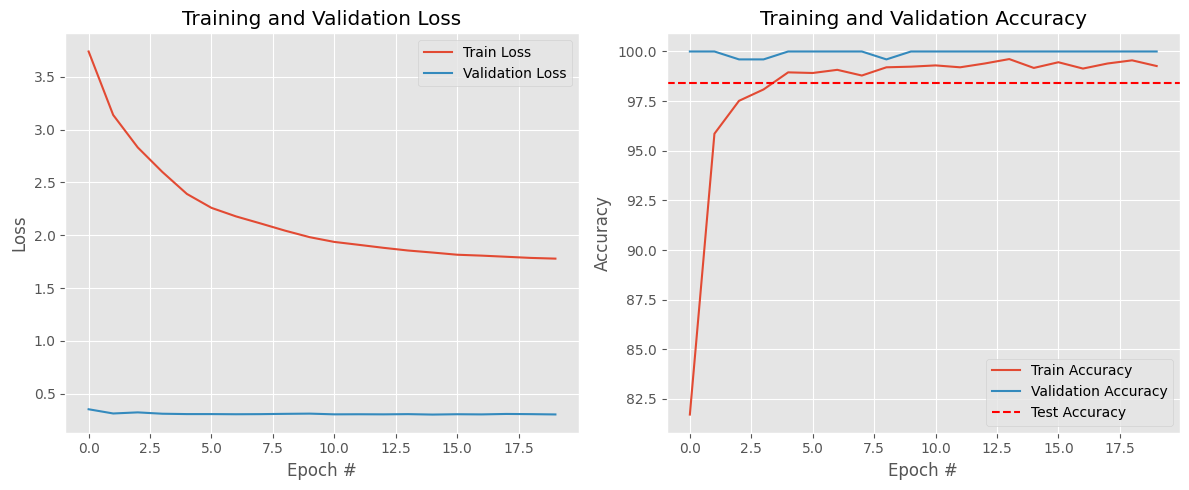

In [74]:
test_acc = evaluate_model(
    model = model, 
    device = device, 
    test_loader = test_loader,
    confusion_matrix = True
)
print(f"La precisión del modelo en test es del {test_acc:.3f}%")

plot_training_curves(
    train_losses = train_losses,
    num_epochs = epochs_number,
    train_accs = train_accs, 
    val_losses = val_losses,
    val_accs = val_accs,
    test_acc=test_acc
)

Podemos sacar las siguientes conclusiones:

* El accuracy general es notablemnte alto.

* El modelo clasifica bien los datos de engagement bajo.

* El modelo no clasifica del todo bien los datos de engagement alto, mostrando cierta incertidumbre en su clasificación entre engagement alto o neutro. En los ejemplos de test ha dado 5 casos de falso positivo de engagement neutro, o lo que es lo mismo, 5 casos de falso negativo de engagement alto, siendo esto un 25% de error de clasificación de los datos de engagement alto. Por otra parte, no observamos errores de predicción extremos (predicción de engagement bajo con target real de engagement alto).

* No podemos concluir nada con certeza sobre cómo realiza la clasificación de datos con engagement neutro, ya que el Dataset de test no disponía de estos datos por la imposibilidad de estratificar en la división de los datos (no se pudo estratificar porque la métrica de engagement elegida requiere de escalado MinMax, lo cual debe hacerse en función de los datos de train). Aunque sepamos que en validation se han clasificado bien, no podemos tomarlo como métrica, ya que al haber utilizado las métricas de validación como objetivo de optimización de hiperparámetros y haber sido estas un factor clave en la elección del modelo, evaluar el modelo final según los datos de validación sería sesgar esta evaluación.